# Lab 3 — recommender systems

In [3]:
import json
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
plt.style.use("ggplot")

What does the data look like?

In [4]:
!hdfs dfs -cat /ix/ml-20m/ratings.txt | tail -n 2

{"movieId": 70286, "userId": 138493, "timestamp": 1258126944, "rating": 5.0}
{"movieId": 71619, "userId": 138493, "timestamp": 1255811136, "rating": 2.5}


In [5]:
data = sc.textFile("/ix/ml-20m/ratings.txt").map(json.loads)

## Exercise 3.4 Basic statistics :

Users :

In [6]:
users_ratings = data.map(lambda x: (x['userId'], x['rating']))
users_counts = users_ratings.countByKey().items()

Movies

In [7]:
movies_ratings = data.map(lambda x: (x['movieId'], x['rating']))
movies_counts = movies_ratings.countByKey().items()

Now let's plot :

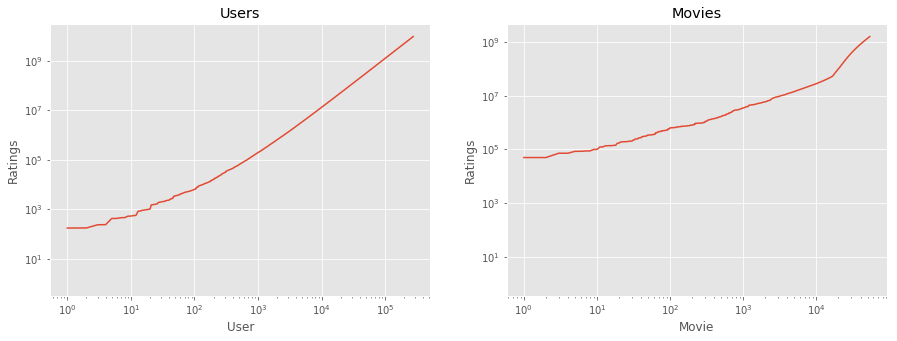

In [8]:
cumulative_users = np.cumsum(sorted(list(users_counts)))
cumulative_movies = np.cumsum(sorted(list(movies_counts)))

fig, (axe1, axe2) = plt.subplots(ncols=2, figsize=(15, 5))
axe1.plot(cumulative_users)
axe1.set_title("Users")
axe1.set_xlabel('User')
axe1.set_ylabel('Ratings')

axe2.plot(cumulative_movies)
axe2.set_title("Movies")
axe2.set_xlabel('Movie')
axe2.set_ylabel('Ratings')

axe2.loglog()
axe1.loglog()

plt.show()

Some users have a lot of ratings as well as movies and users having little number of ratings. The distributions of the ratings isn't balanced uniformly.

## Exercise 3.5 Partitioning the dataset :

In [9]:
personnal_ratings = list() ## add the personnal ranking somehow
with open("my-ratings.txt") as f :
    for line in f:
        personnal_ratings.append(json.loads(line.strip()))

newData = data.union(sc.parallelize(personnal_ratings))

training = newData.filter(lambda x: (x['timestamp'] % 10) > 1).map(lambda x: (x['userId'], x['movieId'], x['rating']))
test = newData.filter(lambda x: (x['timestamp'] % 10) <= 1).map(lambda x: (x['userId'], x['movieId'], x['rating']))

### Baseline recommender system

#### Baseline model

In [10]:
mu = training.map(lambda x: x[2]).mean()

In [11]:
mu

3.5255073364131326

In [12]:
## find how to get all_user_bias and all_item_bias
all_user_mean = training.map(lambda x: (x[0], x[2])).aggregateByKey((0,0), lambda a,b: (a[0] + b,a[1] + 1), lambda a,b: (a[0] + b[0], a[1] + b[1])).mapValues(lambda v: v[0]/v[1])
all_user_bias = all_user_mean.map(lambda x: (x[0], x[1]-mu))

In [13]:
mean_user_bias = all_user_bias.values().mean()
mean_user_bias

0.10160805230563542

In [20]:
collected_all_user_bias = all_user_bias.collectAsMap()

In [21]:
all_item_bias = training.map(lambda x: (x[1], x[2] - collected_all_user_bias[x[0]] - mu)).aggregateByKey((0,0), lambda a,b: (a[0] + b,a[1] + 1), lambda a,b: (a[0] + b[0], a[1] + b[1])).mapValues(lambda v: v[0]/v[1])

In [22]:
mean_item_bias = all_item_bias.values().mean()
mean_item_bias

-0.20496287461285176

In [23]:
def user_bias(userId):
    if userId in all_user_bias.keys():
        return all_user_bias[userId]
    
    return mean_user_bias

def item_bias(movieId):
    if movieId in all_item_bias.keys():
        return all_item_bias[movieId]
    
    return mean_item_bias

In [24]:
def predict(user, movie):
    return ((user, movie), mu + user_bias(user) + item_bias(movie))

In [25]:
def predict_all(users_movies):
    return users_movies.map(lambda x: predict(x[0], x[1]))


#### Evaluation

In [26]:
def errorFct(rdd):
    ranks_predictions = test.map(lambda x: ((x[0], x[1]), x[2])).join(rdd)
    
    errors = ranks_predictions.map(lambda t: (t[0][0], (t[1][0] - t[1][1]) ** 2))
    
    error_mean = errors.aggregateByKey((0,0), lambda a,b: (a[0] + b,a[1] + 1), lambda a,b: (a[0] + b[0], a[1] + b[1])).mapValues(lambda v: v[0]/v[1])
    
    err = error_mean.map(lambda u: np.sqrt(u[1])).mean()
    
    return err

### Matrix-factorization model

In [27]:
from pyspark.mllib.recommendation import ALS

Lower rank implies simpler model, thus a faster training. Higher rank increases the amount of parameters used in the learning process, thus the probability of overfitting increases with the rank.

In [28]:
## Choose the rank ? (Shall we use 10 ?)
rank = 5
predictions_param = test.map(lambda x: (x[0],x[1]))

#### Regularization

In [33]:
param = 10e-4
model1 = ALS.train(training, rank, lambda_=param)
prediction = model1.predictAll(predictions_param).map(lambda x: ((x[0], x[1]), x[2]))


error1 = errorFct(prediction)
print('Error with lambda=10^-4: ', error)

Error with lambda=10^-4:  0.834783382938


In [30]:
param2 = 10.0
model2 = ALS.train(training, rank, lambda_=param2)
prediction2 = model2.predictAll(predictions_param).map(lambda x: ((x[0], x[1]), x[2]))


error2 = errorFct(prediction2)
print('Error with lambda=10.0: ', error2)

Error with lambda=10.0:  3.74687983336


In [31]:
## Find optimal lambda below
## optimal_lambda = VALUE
optimal_lambda = 0.1

#### Recommendation

In [41]:
from operator import itemgetter

In [42]:
model = ALS.train(newData.map(lambda x: (x['userId'], x['movieId'], x['rating'])), rank=10, lambda_=optimal_lambda)

movies = sc.textFile("/ix/ml-20m/movies.txt").map(json.loads)
ids_to_title = movies.map(itemgetter("movieId", "title")).collectAsMap()

In [45]:
## Do the recommendation for both users
def user_recommendation(userId, top_n):
    recomendations = model.recommendProducts(userId, top_n)
    movie_ids = [rating[1] for rating in recomendations]
    movies = [ids_to_title[movie_id] for movie_id in movie_ids]
    return movies

In [46]:
first_user = 123
user_recommendation(first_user, 10)

['Marihuana (1936)',
 'No Distance Left to Run (2010)',
 'Bill Hicks: Sane Man (1989)',
 'Moth, The (Cma) (1980)',
 'My Brother Tom (2001)',
 'Flight of the Conchords: A Texan Odyssey (2006)',
 "It's Love I'm After (1937)",
 'Plastic Bag (2009)',
 'Otakus in Love (2004)',
 'I Belong (Som du ser meg) (2012)']

In [47]:
second_user = 138494
user_recommendation(second_user, 10)

['Marihuana (1936)',
 'No Distance Left to Run (2010)',
 'Drained (O cheiro do Ralo) (2006)',
 'Crazy Stone (Fengkuang de shitou) (2006)',
 'Chameleon (Kaméleon) (2008)',
 'Silver Stallion (Silver Brumpy, The) (1993)',
 'Mutant Aliens (2001)',
 "Nicky's Family (2011)",
 'Code Name Coq Rouge (1989)',
 'Afstiros katallilo (2008)']

#### Visualisation

In [ ]:
new_model = ALS.train(training, rank=2, lambda_=optimal_lambda)
selected_movies = sorted(pickle.load(open('selected-movies.pickle', 'rb'), encoding='utf-8'))

In [ ]:
• Create an interactive plot that embeds the movies along the 2 directions defined by the
factorization.
• Describe what you observe. Can you give a name to the dimensions? Do you recognize
cluster of movies that are alike?